In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lbg_forecast.priors_gp_dust as gpdp
dust_prior = gpdp.DustPrior('./', mean=0)
import lbg_forecast.sfh as sfh

Loading Models
Loading Complete


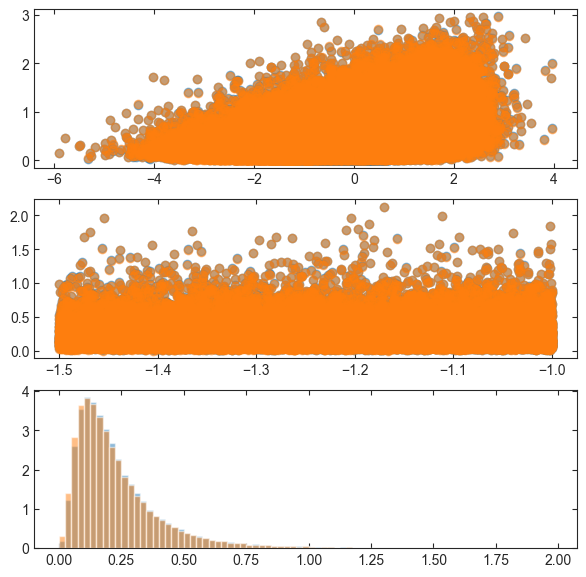

In [2]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(1000000)

new_sfrs = recent_sfrs#np.random.uniform(-4, 3, 100000)
dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(new_sfrs)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(recent_sfrs, dust2, alpha=0.5)
ax[0].scatter(new_sfrs, dust2_gp, alpha=0.5)

sfr_point = -1
inds0 = np.where((recent_sfrs<sfr_point)&(recent_sfrs>sfr_point-0.5))[0]
inds = np.where((new_sfrs<sfr_point)&(new_sfrs>sfr_point-0.5))[0]
ax[1].scatter(recent_sfrs[inds0], dust2[inds0], alpha=0.5)
ax[1].scatter(new_sfrs[inds], dust2_gp[inds], alpha=0.5)

bins = np.arange(0, 2, 0.025)
histogram = ax[2].hist(dust2[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust2_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


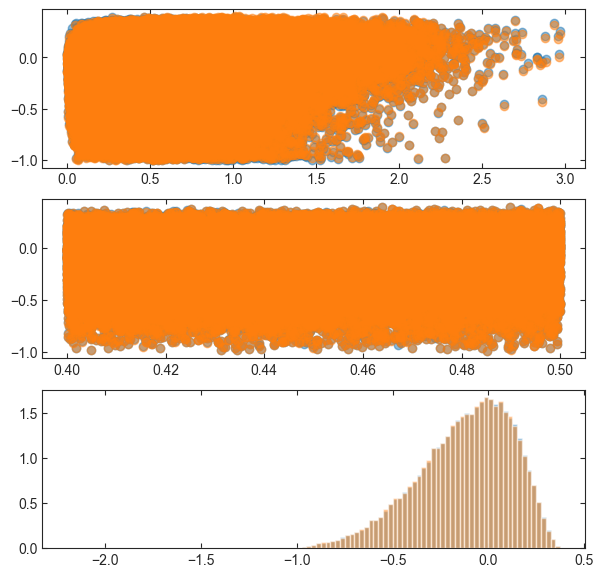

In [3]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(1000000)

dust_prior = gpdp.DustPrior('./')
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = dust2#np.random.uniform(0, 4, 500000)
dust_index_gp = dust_prior.sample_dust_index(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(dust2, dust_index, alpha=0.5)
ax[0].scatter(dust2_gp, dust_index_gp, alpha=0.5)

dust2_point = 0.5
inds0 = np.where((dust2<dust2_point)&(dust2>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(dust2[inds0], dust_index[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust_index_gp[inds], alpha=0.5)

bins = np.arange(-2.2, 0.4, 0.025)
histogram = ax[2].hist(dust_index[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust_index_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


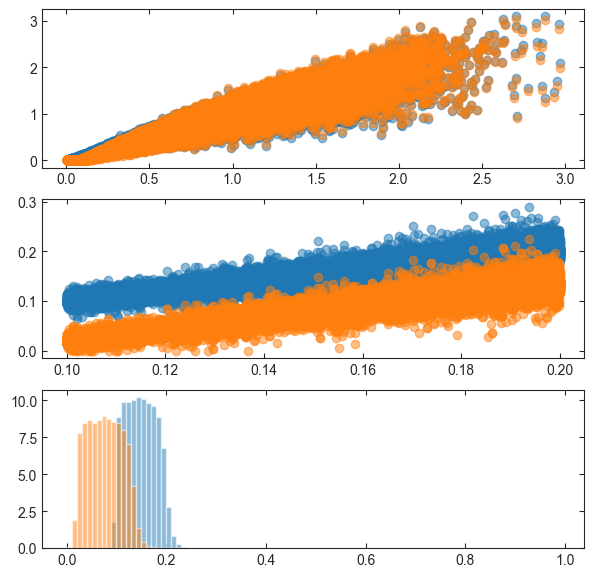

In [4]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(1000000)

dust_prior = gpdp.DustPrior('./')
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = dust2#np.random.uniform(0, 4, 500000)
dust1_gp = dust_prior.sample_dust1(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(dust2, dust1, alpha=0.5)
ax[0].scatter(dust2_gp, dust1_gp, alpha=0.5)

dust2_point = 0.2
inds0 = np.where((dust2<dust2_point)&(dust2>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(dust2[inds0], dust1[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust1_gp[inds], alpha=0.5)

bins = np.arange(0.0, 1.0, 0.01)
histogram = ax[2].hist(dust1[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust1_gp[inds], density=True, bins=bins, alpha=0.5)

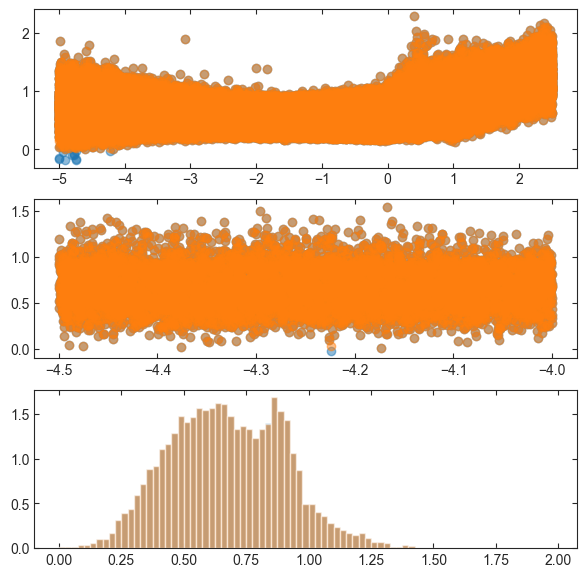

In [136]:
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

new_sfrs = sfr#np.random.uniform(-4, 3, 100000)
dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model_nag(new_sfrs)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(sfr, tau, alpha=0.5)
ax[0].scatter(new_sfrs, dust2_gp, alpha=0.5)

sfr_point = -4
inds0 = np.where((sfr<sfr_point)&(sfr>sfr_point-0.5))[0]
inds = np.where((new_sfrs<sfr_point)&(new_sfrs>sfr_point-0.5))[0]
ax[1].scatter(sfr[inds0], tau[inds0], alpha=0.5)
ax[1].scatter(new_sfrs[inds], dust2_gp[inds], alpha=0.5)

bins = np.arange(0, 2, 0.025)
histogram = ax[2].hist(tau[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust2_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


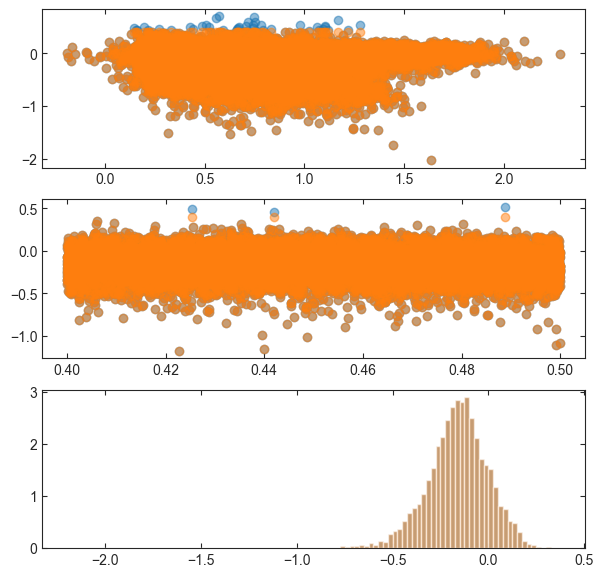

In [132]:
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

dust_prior = gpdp.DustPrior('./')
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = tau#np.random.uniform(0, 4, 500000)
dust_index_gp = dust_prior.sample_dust_index_nag(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(tau, n, alpha=0.5)
ax[0].scatter(dust2_gp, dust_index_gp, alpha=0.5)

dust2_point = 0.5
inds0 = np.where((tau<dust2_point)&(tau>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(tau[inds0], n[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust_index_gp[inds], alpha=0.5)

bins = np.arange(-2.2, 0.4, 0.025)
histogram = ax[2].hist(n[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust_index_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


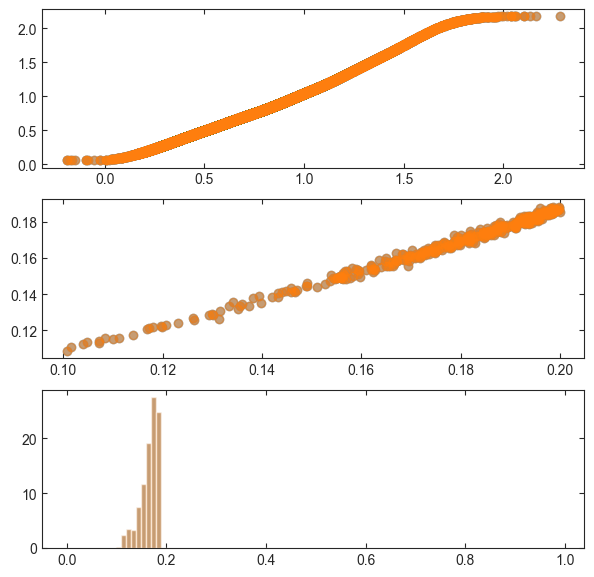

In [7]:
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

dust_prior = gpdp.DustPrior('./')
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = tau#np.random.uniform(0, 4, 500000)
dust1_gp = dust_prior.sample_dust1_nag(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(tau, tau1, alpha=0.5)
ax[0].scatter(dust2_gp, dust1_gp, alpha=0.5)

dust2_point = 0.2
inds0 = np.where((tau<dust2_point)&(tau>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(tau[inds0], tau1[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust1_gp[inds], alpha=0.5)

bins = np.arange(0.0, 1.0, 0.01)
histogram = ax[2].hist(tau1[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust1_gp[inds], density=True, bins=bins, alpha=0.5)

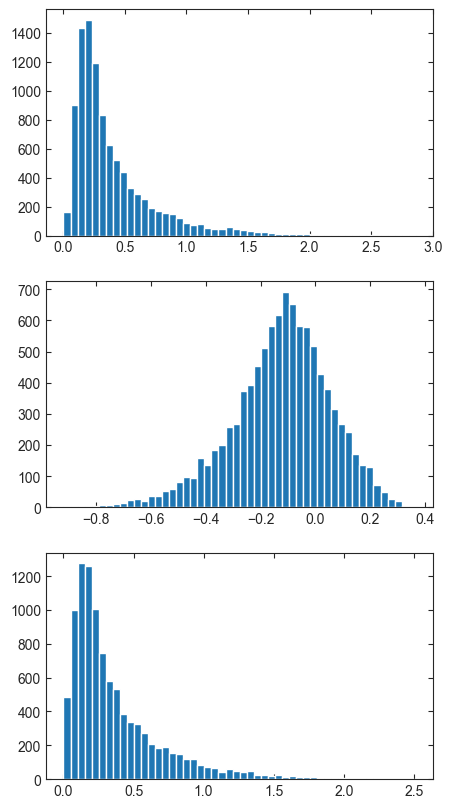

In [189]:
f, ax = plt.subplots(3,1, figsize=(5, 10))
sfr_test = np.random.uniform(-5, 3, 10000)
t2, d, t1 = dust_prior.sample_dust_model(sfr_test)
h1 = ax[0].hist(t2, bins=50)
h2 = ax[1].hist(d, bins=50)
h3 = ax[2].hist(t1, bins=50)

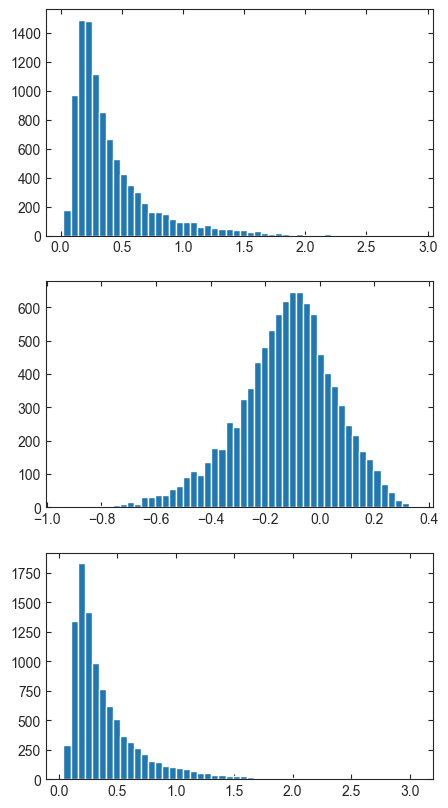

In [127]:
f, ax = plt.subplots(3,1, figsize=(5, 10))
sfr_test = np.random.uniform(-5, 3, 10000)
t2, d, t1 = dust_prior.sample_dust_model(sfr_test)
h1 = ax[0].hist(t2, bins=50)
h2 = ax[1].hist(d, bins=50)
h3 = ax[2].hist(t1, bins=50)

run = 'test'
spsp = np.load("sps_parameter_samples/sps_"+run+".npy")
photometry = np.load("photo_samples/photo_"+run+".npy")
nzs = np.load("nz_samples/nz_"+run+".npy", allow_pickle=True)

print(spsp.shape, nzs)

print(spsp.shape)
f, ax = plt.subplots(3, 1, figsize=(15, 15))
recent_sfrs_pop, dust2_pop, dust_index_pop, dust1_pop = dust_prior.get_pop_cosmos_samples(1000000)

for i in range(spsp.shape[0]):

    sps_real = spsp[i]
    redshifts = sps_real[:, 0]
    logmasses = sps_real[:, -1]
    logsfrratios = sps_real[:, 10:-1]
    dust = sps_real[:, 2:5]
    dust1 = dust[:, 0]
    dust_index = dust[:, 2]
    dust2 = dust[:, 1]
    recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, logmasses, logsfrratios))

    d2x, d2y, d2yerr = gpdp.process_samples(recent_sfrs, dust2, -5, 3)
    ax[0].errorbar(d2x, d2y, d2yerr, fmt='o')
    ax[0].fill_between(d2x, d2y-d2yerr, d2y+d2yerr, alpha=0.1)

    dix, diy, diyerr = gpdp.process_samples(dust2, dust_index, 0, 4)
    ax[1].errorbar(dix, diy, diyerr, fmt='o')
    ax[1].fill_between(dix, diy-diyerr, diy+diyerr, alpha=0.1)

    d1x, d1y, d1yerr = gpdp.process_samples(dust2, dust1, 0, 4)
    ax[2].errorbar(d1x, d1y, d1yerr, fmt='o')
    ax[2].fill_between(d1x, d1y-d1yerr, d1y+d1yerr, alpha=0.1)

d2x, d2y, d2yerr = gpdp.process_samples(recent_sfrs_pop, dust2_pop, -5, 3)
ax[0].errorbar(d2x, d2y, d2yerr, fmt='ko')
ax[0].fill_between(d2x, d2y-d2yerr, d2y+d2yerr, alpha=0.1, color='k')

dix, diy, diyerr = gpdp.process_samples(dust2_pop, dust_index_pop, 0, 4)
ax[1].errorbar(dix, diy, diyerr, fmt='ko')
ax[1].fill_between(dix, diy-diyerr, diy+diyerr, alpha=0.1, color='k')

d1x, d1y, d1yerr = gpdp.process_samples(dust2_pop, dust1_pop, 0, 4)
ax[2].errorbar(d1x, d1y, d1yerr, fmt='ko')
ax[2].fill_between(d1x, d1y-d1yerr, d1y+d1yerr, alpha=0.1, color='k')

ax[0].set_xlim(-5, 3)


print(spsp.shape)
f, ax = plt.subplots(3, 1, figsize=(15, 15))
recent_sfrs_pop, dust2_pop, dust_index_pop, dust1_pop = dust_prior.get_pop_cosmos_samples(1000000)

sfr_point = 0
d2_point = 1.0
d2_point2 = 0.15
dsfr = 0.5
dd2 = 0.1
dd22 = 0.1
d2_bins = np.arange(0.0, 4.0, 0.025)
dibins = np.arange(-2.2, 0.4, 0.025)

for i in range(spsp.shape[0]):

    sps_real = spsp[i]
    redshifts = sps_real[:, 0]
    logmasses = sps_real[:, -1]
    logsfrratios = sps_real[:, 10:-1]
    dust = sps_real[:, 2:5]
    dust1 = dust[:, 0]
    dust_index = dust[:, 2]
    dust2 = dust[:, 1]
    recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshifts, logmasses, logsfrratios))
    
    inds = np.where((recent_sfrs<sfr_point)&(recent_sfrs>sfr_point-dsfr))[0]
    histogram = ax[0].hist(dust2[inds], density=True, bins=d2_bins, alpha=0.25)

    inds = np.where((dust2<dust2_point)&(dust2>dust2_point-dd2))[0]
    histogram = ax[1].hist(dust_index[inds], density=True, bins=dibins, alpha=0.25)

    inds = np.where((dust2<d2_point2)&(dust2>d2_point2-dd22))[0]
    histogram = ax[2].hist(dust1[inds], density=True, bins=d2_bins, alpha=0.25)

inds0 = np.where((recent_sfrs_pop<sfr_point)&(recent_sfrs_pop>sfr_point-dsfr))[0]
histogram = ax[0].hist(dust2_pop[inds0], density=True, bins=d2_bins, color='k', zorder=-1)

inds0 = np.where((dust2_pop<dust2_point)&(dust2_pop>dust2_point-dd2))[0]
histogram = ax[1].hist(dust_index_pop[inds0], density=True, bins=dibins, color='k', zorder=-1)

inds0 = np.where((dust2_pop<d2_point2)&(dust2_pop>d2_point2-dd22))[0]
histogram = ax[2].hist(dust1_pop[inds0], density=True, bins=d2_bins, color='k', zorder=-1)

In [8]:
#np.save("dust_data/popcosmos_recentsfrs.npy", dust_prior.recent_sfrs)
#nagaraj22 = np.array([dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr])
#np.save("dust_data/saved_nagaraj22samples.npy", nagaraj22)

recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(1000000)
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

d2xpop, d2ypop, d2yerrpop = gpdp.process_samples(recent_sfrs, dust2, -5, 3, 30)
plt.scatter(d2xpop, d2ypop)
plt.plot(dust_prior.dust2_grid, dust_prior.dust2_mean())

d2xnag, d2ynag, d2errnag = gpdp.process_samples(sfr, tau, -5, 3, 15)
plt.scatter(d2xnag, d2ynag)
plt.plot(dust_prior.dust2_grid, dust_prior.dust2_mean_nagaraj())

nplots = 15
for f in range(nplots):
    plt.plot(dust_prior.dust2_grid, dust_prior.interpolate_models(f/nplots), alpha=0.25, color='grey')

print(d2ypop, d2ynag)



In [222]:
run = 'pop'
spsp = np.load("sps_parameter_samples/sps_"+run+".npy")[0, :10000, :]
spsp.shape

(10000, 17)

In [223]:
spsp = spsp[np.where((spsp[:, 0] < 3.0) & (spsp[:, 0] > 0.5))[0]]
spsp.shape

(6725, 17)

In [ ]:
## DONT DELETE
import lbg_forecast.sfh as sfh

from duste.DustAttnCalc import DustAttnCalc
ngal = spsp.shape[0]

logM = np.log10(spsp[:, -1])#np.random.uniform(8.74,11.30,ngal)
sfr = np.log10(sfh.calculate_recent_sfr(spsp[:, 0], spsp[:, -1], spsp[:, 10:-1]))#np.random.uniform(-2,2,ngal)
logZ = spsp[:, 1]#np.random.uniform(-1.70,0.18,ngal)
z= spsp[:, 0]#np.random.uniform(0.51,2.83,ngal)
i=np.random.uniform(0.09,0.97,ngal)
dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, z=z, bv=True, eff=False)
dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
Measured grid length f

<ErrorbarContainer object of 3 artists>

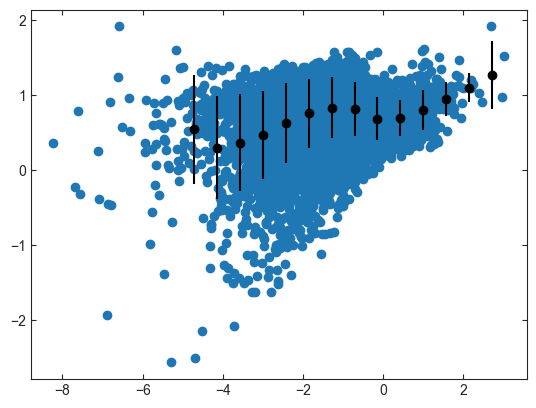

In [225]:
plt.scatter(sfr, tau)
x, y, yerr = gpdp.process_samples(sfr, tau, -5, 3, 15)
plt.errorbar(x, y, yerr, fmt='ko')

In [ ]:
#nagaraj_data = np.vstack((n, tau, tau1, ne, taue, tau1e, sfr))
#np.save("dust_data/saved_nagaraj22samples.npy", nagaraj_data)